Using device: mps
Training data length   = 2500 hours
Validation data length = 2500 hours
Episode 1/50 | Reward=-0.3424 | TrainLoss=0.001619 | ValLoss=0.001475 | ε=1.000
Episode 2/50 | Reward=-0.0935 | TrainLoss=0.001466 | ValLoss=0.001666 | ε=0.982
Episode 3/50 | Reward=0.0232 | TrainLoss=0.001495 | ValLoss=0.001579 | ε=0.965
Episode 4/50 | Reward=-0.0616 | TrainLoss=0.001455 | ValLoss=0.001347 | ε=0.948
Episode 5/50 | Reward=0.0746 | TrainLoss=0.001478 | ValLoss=0.001552 | ε=0.931
Episode 6/50 | Reward=-0.2010 | TrainLoss=0.001470 | ValLoss=0.001534 | ε=0.914
Episode 7/50 | Reward=-0.7417 | TrainLoss=0.001475 | ValLoss=0.001497 | ε=0.898
Episode 8/50 | Reward=-0.2954 | TrainLoss=0.001462 | ValLoss=0.001569 | ε=0.882
Episode 9/50 | Reward=0.0358 | TrainLoss=0.001445 | ValLoss=0.001456 | ε=0.867
Episode 10/50 | Reward=-0.4925 | TrainLoss=0.001462 | ValLoss=0.000028 | ε=0.852
Episode 11/50 | Reward=-0.4803 | TrainLoss=0.000043 | ValLoss=0.000017 | ε=0.837
Episode 12/50 | Reward=-0.2802 

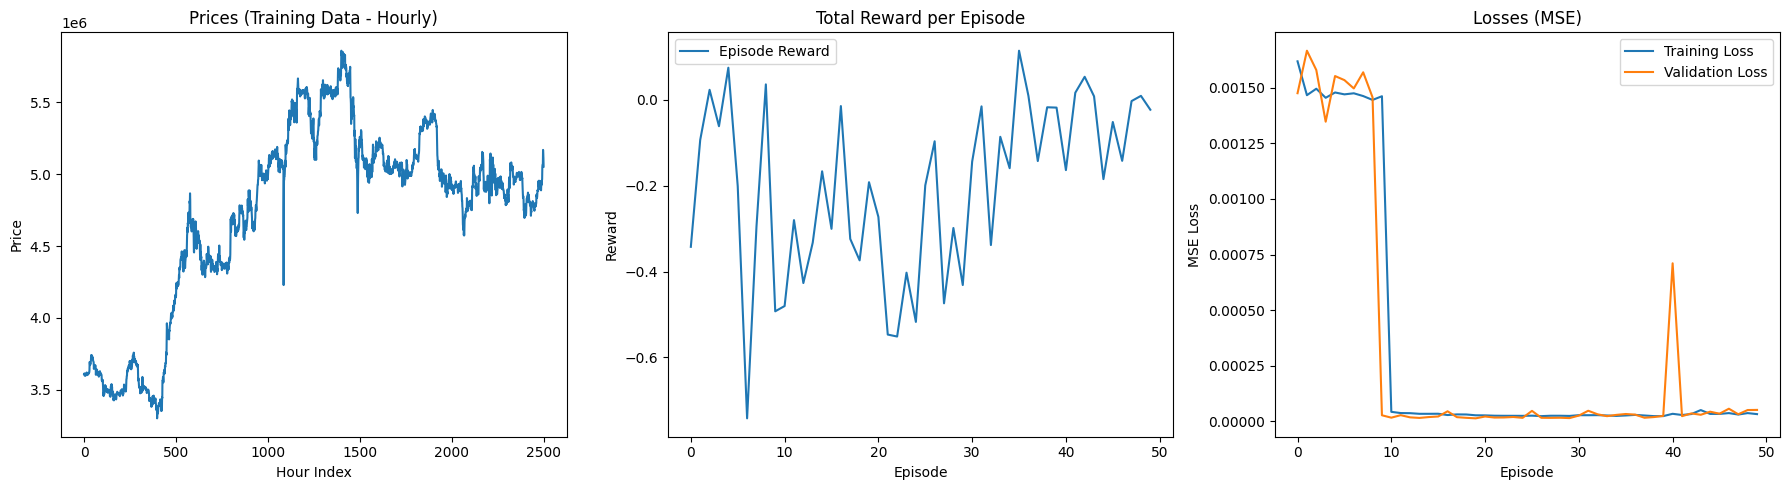


----- Validation Results (Hourly) -----
 Starting Balance: 5,000,000.00 KRW
 Final Balance:    3,255,063.34 KRW
 Total PnL:        -1,744,936.66 KRW (-34.90%)


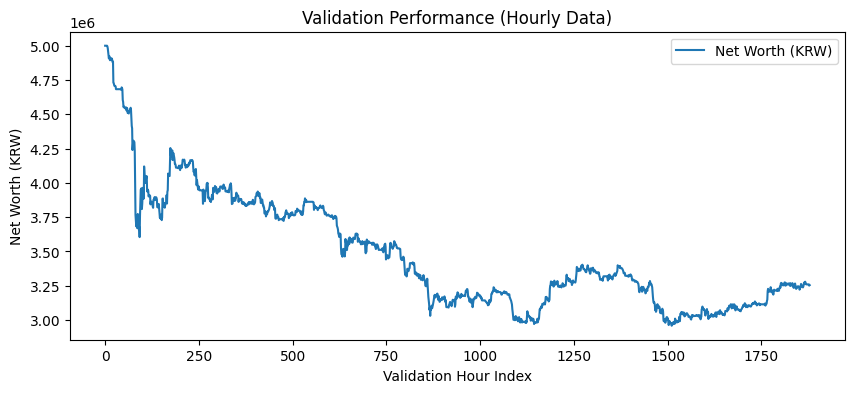

In [4]:
'''Patch Note 2 --> 3
Introduction of various regularization methods

neuronal dropout nn.Dropout(0.1) in the MLP
stronger regularization coefficient from 1e-2 to 1e-1
'''

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Device selection
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
)
print(f"Using device: {device}")

def fetch_historical_data(quote="KRW", target="ETH", hours=5000):
    """
    Fetches 'hours' of historical data.
    
    Uses the Bithumb 1h candlestick endpoint:
    https://api.bithumb.com/public/candlestick/{target}_{quote}/1h
    
    Returns a NumPy array of closing prices (floats).
    """
    base_url = f"https://api.bithumb.com/public/candlestick/{target}_{quote}/1h"
    
    try:
        response = requests.get(base_url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        if data.get("status") != "0000":
            print(f"API Error: {data.get('message', 'Unknown error')}")
            return None
            
        candlesticks = data.get("data", [])
        if not candlesticks:
            print("No hourly data found in response.")
            return None
            
        # Each entry: [timestamp, open, close, high, low, volume]
        prices = [float(entry[2]) for entry in candlesticks[-hours:]]
        return np.array(prices, dtype=np.float32)
        
    except Exception as e:
        print(f"Error fetching hourly data: {str(e)}")
        return None

class EnhancedTradingEnv:
    """
    Environment for trading on a sequence of hourly prices.
    Each step moves forward by 1 hour in 'prices'.
    - Includes a transaction fee (e.g. 0.1%) for buys and sells.
    - Randomly chooses the start index for each episode (to avoid memorizing a single sequence).
    """
    def __init__(self, prices, window_size=30, initial_balance=100000.0, fee_rate=0.001):
        self.prices = prices
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate  # e.g., 0.1% transaction fee
        self.reset()
        
    def reset(self):
        # Randomly pick a starting step that leaves enough room
        self.current_step = random.randint(self.window_size, len(self.prices) - 1)
        self.balance = self.initial_balance
        self.position = 0.0
        # Initialize net_worth history with window_size entries (for the reward log calc)
        self.net_worth = [self.initial_balance] * self.window_size
        return self._get_observation()
    
    def _get_observation(self):
        # Last 'window_size' hours of prices
        price_window = self.prices[self.current_step - self.window_size : self.current_step]
        
        # Normalize
        mean_p = np.mean(price_window)
        std_p = np.std(price_window) if np.std(price_window) > 0 else 1.0
        normalized_prices = (price_window - mean_p) / std_p
        
        # Simple volatility indicator
        returns = np.diff(price_window) / price_window[:-1] if len(price_window) > 1 else [0]
        volatility = np.std(returns) if len(returns) > 1 else 0.0
        
        # Combine features (prices + 3 extras)
        return np.concatenate([
            normalized_prices,
            [
                self.balance / self.initial_balance,
                self.position,
                volatility
            ]
        ]).astype(np.float32)
    
    def step(self, action):
        current_price = self.prices[self.current_step]
        
        # Action space: 0=hold, 1=buy, 2=sell
        if action == 1:  # Buy
            max_buy = self.balance / current_price
            # Apply fee on the total purchased
            cost = max_buy * current_price
            fee = cost * self.fee_rate
            self.position += max_buy
            self.balance -= (cost + fee)
        elif action == 2:  # Sell
            # Sell entire position
            proceeds = self.position * current_price
            fee = proceeds * self.fee_rate
            self.balance += (proceeds - fee)
            self.position = 0.0
            
        # Update net worth
        current_net_worth = self.balance + self.position * current_price
        self.net_worth.append(current_net_worth)
        
        # Reward = log change in net worth (avoid log(0))
        prev_worth = self.net_worth[-2]
        reward = 0.0 if prev_worth <= 0 else np.log(current_net_worth / prev_worth)
        
        # Move forward
        self.current_step += 1
        
        # Episode ends if we reach the end of the price array
        done = (self.current_step >= len(self.prices) - 1)
        
        return self._get_observation(), reward, done

class CNN_DQN(nn.Module):
    """
    CNN-based DQN for trading on hourly data.
    Includes dropout layers to help regularize and avoid overfitting.
    """
    def __init__(self, window_size, num_actions, dropout_p=0.2):
        super(CNN_DQN, self).__init__()
        self.window_size = window_size

        # 1D CNN feature extractor for prices
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(dropout_p),  # Dropout after first conv block

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(dropout_p)  # Dropout after second conv block
        )
        conv_out_size = self._conv_out(window_size)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size + 3, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_actions)
        )

    def _conv_out(self, size):
        with torch.no_grad():
            o = self.conv(torch.zeros(1, 1, size))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        # x shape: (batch_size, window_size + 3)
        batch_size = x.size(0)
        
        # First 'window_size' elements -> CNN
        prices = x[:, :self.window_size]  
        extra  = x[:, self.window_size:]  
        
        conv_input = prices.unsqueeze(1)       # (batch_size, 1, window_size)
        conv_output = self.conv(conv_input)
        conv_flat = conv_output.view(batch_size, -1)
        
        # Concatenate the 3 extra features
        combined = torch.cat([conv_flat, extra], dim=1)
        q_values = self.fc(combined)
        return q_values

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

def compute_validation_loss(model, target_net, prices, window_size, initial_balance, gamma=0.99, batch_size=64):
    """
    Runs a single "episode" in a validation environment (greedy policy),
    collects transitions, and computes average MSE loss vs. the target network
    without performing any gradient updates.
    """
    env = EnhancedTradingEnv(prices=prices, window_size=window_size, initial_balance=initial_balance)
    state = env.reset()
    done = False
    transitions = []
    
    # 1) Generate transitions (greedy policy)
    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_tensor).argmax(dim=1).item()
        next_state, reward, done = env.step(action)
        transitions.append((state, action, reward, next_state, done))
        state = next_state
    
    # 2) Compute MSE in batches
    total_loss = 0.0
    count = 0
    
    mse = nn.MSELoss()
    with torch.no_grad():
        for i in range(0, len(transitions), batch_size):
            batch = transitions[i:i+batch_size]
            states, actions, rewards_, next_states, dones = zip(*batch)
            
            states_t      = torch.FloatTensor(states).to(device)
            actions_t     = torch.LongTensor(actions).to(device)
            rewards_t     = torch.FloatTensor(rewards_).to(device)
            next_states_t = torch.FloatTensor(next_states).to(device)
            dones_t       = torch.BoolTensor(dones).to(device)
            
            # Current Q
            current_q = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)
            
            # Target Q (from target_net)
            next_q = target_net(next_states_t).max(dim=1)[0]
            target_q = rewards_t + gamma * next_q * (~dones_t)
            
            loss = mse(current_q, target_q)
            total_loss += loss.item() * len(batch)
            count += len(batch)
    
    avg_val_loss = total_loss / count if count > 0 else 0.0
    return avg_val_loss

def validate_model(model, prices, window_size=30, initial_balance=10000.0):
    """
    Runs a validation episode on 'prices' (hourly) using a purely greedy policy
    from the trained 'model'. Returns hour-by-hour records.
    """
    env = EnhancedTradingEnv(prices=prices, window_size=window_size, initial_balance=initial_balance)
    state = env.reset()
    
    done = False
    prev_net_worth = env.net_worth[-1]
    hourly_records = []
    
    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_tensor).argmax(dim=1).item()
        
        next_state, _, done = env.step(action)
        current_net_worth = env.net_worth[-1]
        
        hourly_pnl = current_net_worth - prev_net_worth
        hourly_records.append({
            "hour_index": env.current_step,
            "action": action,
            "net_worth": current_net_worth,
            "hourly_pnl": hourly_pnl
        })
        
        prev_net_worth = current_net_worth
        state = next_state
    
    final_balance = env.net_worth[-1]
    total_pnl = final_balance - initial_balance
    pct_return = (total_pnl / initial_balance) * 100.0
    
    print("\n----- Validation Results (Hourly) -----")
    print(f" Starting Balance: {initial_balance:,.2f} KRW")
    print(f" Final Balance:    {final_balance:,.2f} KRW")
    print(f" Total PnL:        {total_pnl:,.2f} KRW ({pct_return:.2f}%)")
    
    return hourly_records

def plot_training_progress(episode_rewards, prices, training_losses, validation_losses):
    """
    Plots:
      1) The training price series,
      2) The total reward per episode,
      3) The training loss vs. validation loss for each episode.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1) Price plot
    axs[0].plot(prices)
    axs[0].set_title("Prices (Training Data - Hourly)")
    axs[0].set_xlabel("Hour Index")
    axs[0].set_ylabel("Price")
    
    # 2) Reward plot
    axs[1].plot(episode_rewards, label="Episode Reward")
    axs[1].set_title("Total Reward per Episode")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Reward")
    axs[1].legend()
    
    # 3) Loss plot (one point per episode)
    axs[2].plot(training_losses, label="Training Loss")
    axs[2].plot(validation_losses, label="Validation Loss")
    axs[2].set_title("Losses (MSE)")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("MSE Loss")
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 1) Fetch data
    coin = "ETH"
    quote = "KRW"
    total_hours = 5000
    all_prices = fetch_historical_data(quote=quote, target=coin, hours=total_hours)
    
    if all_prices is None or len(all_prices) < total_hours:
        print("Failed to fetch enough hourly data.")
        exit(1)
        
    # 2) Split data (e.g. half for training, half for validation)
    split_index = len(all_prices) // 2
    training_prices   = all_prices[split_index:]
    validation_prices = all_prices[:split_index]
    
    print(f"Training data length   = {len(training_prices)} hours")
    print(f"Validation data length = {len(validation_prices)} hours")
    
    # 3) Environment (with transaction fee)
    env = EnhancedTradingEnv(prices=training_prices, window_size=30, initial_balance=10000, fee_rate=0.001)
    state_size = len(env._get_observation())  # should be 33
    num_actions = 3
    
    # 4) Initialize model and target network (with dropout)
    model = CNN_DQN(window_size=30, num_actions=num_actions, dropout_p=0.3).to(device)
    target_net = CNN_DQN(window_size=30, num_actions=num_actions, dropout_p=0.3).to(device)
    target_net.load_state_dict(model.state_dict())
    
    # 5) Training hyperparams
    # - Use AdamW with weight_decay (L2 regularization)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)
    replay_buffer = ReplayBuffer(capacity=20000)  # Slightly bigger replay buffer
    
    batch_size = 64
    gamma = 0.99
    
    # Slow down epsilon decay, start with full exploration
    epsilon_start = 1.0
    epsilon_end   = 0.1
    epsilon_decay = 50.0
    
    # Train more episodes (e.g. 50 or 100). Start with 50 here:
    episodes = 50
    
    episode_rewards = []
    training_losses = []    
    validation_losses = []  
    
    # 6) Training loop
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0.0
        episode_loss = 0.0
        training_steps = 0
        
        # Epsilon decay
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1.0 * episode / epsilon_decay)
        
        done = False
        while not done:
            # Epsilon-greedy
            if random.random() > epsilon:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = model(state_tensor).argmax(dim=1).item()
            else:
                action = random.randint(0, num_actions - 1)
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            
            # Training step if enough samples in the buffer
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states_b, actions_b, rewards_b, next_states_b, dones_b = zip(*batch)
                
                states_t      = torch.FloatTensor(states_b).to(device)
                actions_t     = torch.LongTensor(actions_b).to(device)
                rewards_t     = torch.FloatTensor(rewards_b).to(device)
                next_states_t = torch.FloatTensor(next_states_b).to(device)
                dones_t       = torch.BoolTensor(dones_b).to(device)
                
                # Current Q
                current_q = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)
                
                # Target Q
                with torch.no_grad():
                    next_q = target_net(next_states_t).max(dim=1)[0]
                    target_q = rewards_t + gamma * next_q * (~dones_t)
                
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                episode_loss += loss.item()
                training_steps += 1
        
        # Update target net every 10 episodes (instead of every episode)
        if (episode + 1) % 10 == 0:
            target_net.load_state_dict(model.state_dict())
        
        # Compute final episode stats
        episode_rewards.append(total_reward)
        avg_train_loss = episode_loss / training_steps if training_steps > 0 else 0.0
        training_losses.append(avg_train_loss)
        
        # Compute validation loss after each episode
        val_loss = compute_validation_loss(
            model, 
            target_net, 
            prices=validation_prices, 
            window_size=30, 
            initial_balance=10000.0,
            gamma=gamma,
            batch_size=batch_size
        )
        validation_losses.append(val_loss)
        
        print(f"Episode {episode+1}/{episodes} | "
              f"Reward={total_reward:.4f} | "
              f"TrainLoss={avg_train_loss:.6f} | "
              f"ValLoss={val_loss:.6f} | "
              f"ε={epsilon:.3f}")
    
    # 7) Plot
    plot_training_progress(episode_rewards, training_prices, training_losses, validation_losses)
    
    # 8) Final validation run
    validation_start_balance = 5_000_000.0
    validation_data = validate_model(
        model,
        prices=validation_prices, 
        window_size=30, 
        initial_balance=validation_start_balance
    )
    
    # 9) Plot net worth over validation
    networth_vals = [r["net_worth"] for r in validation_data]
    plt.figure(figsize=(10, 4))
    plt.plot(networth_vals, label="Net Worth (KRW)")
    plt.title("Validation Performance (Hourly Data)")
    plt.xlabel("Validation Hour Index")
    plt.ylabel("Net Worth (KRW)")
    plt.legend()
    plt.show()

    '''
    Improvement	Old Code	New Code	Impact
Transaction Fees	❌ No fees	✅ fee_rate=0.001	Prevents excessive trading, improves realism
Dropout Regularization	❌ No dropout	✅ Dropout(0.3) in CNN & FC layers	Reduces overfitting, improves generalization
Epsilon Decay	🔴 Too fast (10)	✅ Slower (50)	More exploration, prevents premature convergence
Target Network Updates	❌ Every episode	✅ Every 10 episodes	Prevents instability in training
Number of Training Episodes	❌ 15 episodes	✅ 50 episodes	Allows deeper learning, prevents premature convergence
Replay Buffer Size	❌ 10,000	✅ 20,000	Retains more experience for training stability
Validation Loss Monitoring	❌ Not consistent	✅ Every episode	Detects overfitting earlier
    '''


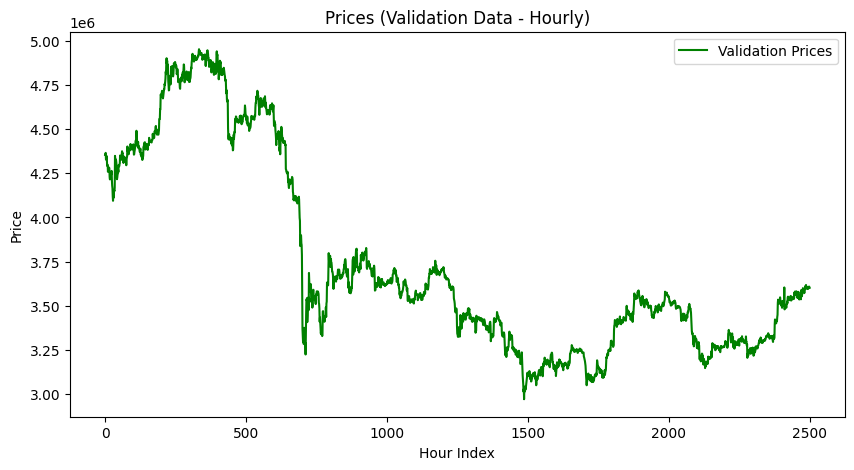

In [5]:
import matplotlib.pyplot as plt

def plot_validation_prices(validation_prices):
    """
    Plots the validation price series separately.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(validation_prices, color='green', label="Validation Prices")
    plt.title("Prices (Validation Data - Hourly)")
    plt.xlabel("Hour Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# ✅ Call this function after validation in a separate Jupyter Notebook cell
plot_validation_prices(validation_prices)
